In [16]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense,Conv2D,AveragePooling2D,UpSampling2D
from tensorflow.keras.applications.vgg16 import preprocess_input,decode_predictions
import os
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

# Dataset Creation 

**Creating the dataset for content and style images-** 
The style images used for the style transfer algorithm implemented in this notebook were taken from the work of the artist Alfred Sisley while the content images were choosen to be tranvel and adventure images from the image-classification dataset on kaggle.


In [2]:
path_style = '/kaggle/input/artworks-dataset/images/images/Alfred_Sisley'
X_style=[]
num_images = 0
for img in os.listdir(path_style):
    num_images+=1
    if(num_images<=500):
        image_path=path_style+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        img_arr=img_arr/255.0
        X_style.append(img_arr)

path_content = '/kaggle/input/image-classification/images/images/travel and  adventure'
X_content=[]
for img in os.listdir(path_content):
    if(len(X_content)<num_images):
        image_path=path_content+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        img_arr=img_arr/255.0
        X_content.append(img_arr)      

**Creating the train-test-validation split in order to check the generalization power of the model**

In [3]:
from sklearn.model_selection import train_test_split
X_train_content, X_test = train_test_split(X_content, test_size=0.2, random_state=42)
X_test_content, X_val_content = train_test_split(X_test, test_size=0.5, random_state=42)
X_train_content = np.array(X_train_content)
X_val_content = np.array(X_val_content)
X_test_content = np.array(X_test_content)
X_train_style, X_test = train_test_split(X_style, test_size=0.2, random_state=42)
X_test_style, X_val_style = train_test_split(X_test, test_size=0.5, random_state=42)
X_train_style = np.array(X_train_style)
X_val_style = np.array(X_val_style)
X_test_style = np.array(X_test_style)

# Methodology

**feature_ext_model-**
The idea is to use a pretrained image classification model and use it to extract features of the images from intermediate layers, thus the feature extraction model that I used here is a pre-trained VGG16 model with no feedforward layers(this model is not being trained during the style and content learning).

In [5]:
from keras.applications.vgg16 import VGG16
feature_ext_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
for layer in feature_ext_model.layers:
  layer.trainable = False
print(feature_ext_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**model-** The following convolutional autoencoder model is used to generate an image with content image as its input, the generated image for the given dataset is optimized by training the model by reducing the sum of style and content loss.

In [6]:
model = Sequential()
# encoder network
model.add(Conv2D(64, 3, activation= 'relu', padding='same', input_shape = (224,224,3)))
model.add(AveragePooling2D(2, padding= 'same'))
model.add(Conv2D(128, 3, activation= 'relu', padding='same'))
model.add(AveragePooling2D(2, padding= 'same'))
model.add(Conv2D(256, 3, activation= 'relu', padding='same'))
model.add(AveragePooling2D(2, padding= 'same'))
model.add(Conv2D(256, 3, activation= 'relu', padding='same'))
#decoder network
model.add(Conv2D(256, 3, activation= 'relu', padding='same'))
model.add(UpSampling2D(2))
model.add(Conv2D(128,3,activation='relu', padding= 'same'))
model.add(UpSampling2D(2))
model.add(Conv2D(64,3,activation='relu', padding= 'same'))
model.add(UpSampling2D(2))
model.add(Conv2D(3,3,activation='sigmoid', padding= 'same'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 average_pooling2d (Average  (None, 112, 112, 64)      0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 average_pooling2d_1 (Avera  (None, 56, 56, 128)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       295168    
                                                                 
 average_pooling2d_2 (Avera  (None, 28, 28, 256)       0

**Content Loss-** This loss function calculates the error between the output feature map of the original input image and the generated image, these features are extracted from the content layers of the pre-trained model. In this implementation the content layer selected was the 2nd convolutional layer of the 2nd block of feature_extract_model, this selection was based on the fact that initial layers of a CNN model are able to extract higher level features like edges and local positions of the content of the image and because our goal is to preserve the content of generated image along with styling it according to the artist's style of painting.

In [7]:
content_layers = ['block2_conv2']
def content_loss(model,X):
    gen_image = model(X)
    intermediate_layer_model = Model(inputs=feature_ext_model.input,outputs=feature_ext_model.get_layer(name=content_layers[0]).output)
    y = tf.stop_gradient(intermediate_layer_model(X))
    y_pred = intermediate_layer_model(gen_image)
    return tf.reduce_mean((y_pred-y)**2)

**Style Loss-** This loss function accounts for the style (texture, brush stroke patterns, colour etc.) of the the artist's work. The five style layers used to extract the features are given below and they are choosen to extract some higher level features as well as the lower level features which build up on the lower level features like edges and content to extract the style of the artist.

In [8]:
# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

def gram(tensor):
    temp = tensor
    temp = tf.squeeze(temp)
    fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
    result = tf.matmul(temp, temp, transpose_b=True)
    num_elements = tf.cast(fun.shape[1],dtype=tf.float32)
    result = result / num_elements
    gram = tf.expand_dims(result, axis=0)
    return gram

def style_loss(model,X_style,X_content):
    gen_image = model(X_content)
    loss = 0
    for i in range(len(style_layers)):
        intermediate_layer_model = Model(inputs=feature_ext_model.input,outputs=feature_ext_model.get_layer(name=style_layers[i]).output)
        for j in range(len(X_content)):
            y = tf.stop_gradient(intermediate_layer_model(X_style[j:j+1]))
            y_pred = intermediate_layer_model(gen_image[j:j+1])
            target_gram = gram(y)
            pred_gram = gram(y_pred)
            loss += tf.reduce_mean((pred_gram-target_gram)**2)
        
    return loss/(len(style_layers)*len(X_content))

This section is used for training the model, can be uncommented to further train it on different dataset.

In [ ]:
'''num_epochs = 1000
batchsize = 10

opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, epsilon=1e-1)
for epoch in range(num_epochs):
  for step in range(X_train_content.shape[0]//batchsize):
    start_idx = batchsize*step
    end_idx = batchsize*(step+1)
    X_content_batch = X_train_content[start_idx:end_idx]
    X_style_batch = X_train_style[start_idx:end_idx]
    with tf.GradientTape() as tape:
      loss = 10*style_loss(model,X_style_batch,X_content_batch) + content_loss(model,X_content_batch)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
  val_loss = style_loss(model,X_val_style,X_val_content[0:10]) + content_loss(model,X_val_content[0:10])  
  model.save('/kaggle/working/my_model.h5') 
  print({'training_loss': loss, 'loss': val_loss})'''

In [9]:
# loading the saved model 
model = tf.keras.models.load_model('/kaggle/working/my_model.h5')

# Some Visual Examples

Text(0.5, 1.0, 'Generated Image')

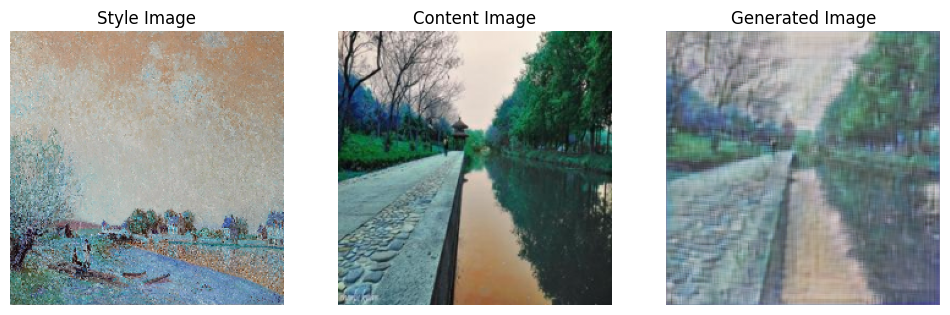

In [14]:
image_style = X_test_style[3]
image_content = X_test_content[13]
image_gen = model(X_test_content[13:14])
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8)) 
  
# setting values to rows and column variables 
rows = 1
columns = 3
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(image_style) 
plt.axis('off') 
plt.title("Style Image") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(image_content) 
plt.axis('off') 
plt.title("Content Image") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(image_gen[0]) 
plt.axis('off') 
plt.title("Generated Image") 

Text(0.5, 1.0, 'Generated Image')

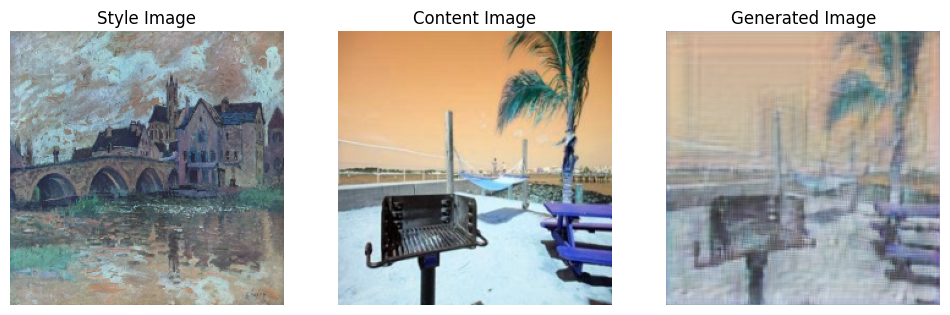

In [15]:
image_style = X_test_style[6]
image_content = X_test_content[8]
image_gen = model(X_test_content[8:9])
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8)) 
  
# setting values to rows and column variables 
rows = 1
columns = 3
  
# Adds a subplot at the 1st position 
fig.add_subplot(rows, columns, 1) 
  
# showing image 
plt.imshow(image_style) 
plt.axis('off') 
plt.title("Style Image") 
  
# Adds a subplot at the 2nd position 
fig.add_subplot(rows, columns, 2) 
  
# showing image 
plt.imshow(image_content) 
plt.axis('off') 
plt.title("Content Image") 
  
# Adds a subplot at the 3rd position 
fig.add_subplot(rows, columns, 3) 
  
# showing image 
plt.imshow(image_gen[0]) 
plt.axis('off') 
plt.title("Generated Image") 